In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt

def arctic_average(xarray, data_string):
    """
    Find monthly averages timeseries.
    """
    if data_string == 'TAS':
        arctic_xarray = xarray.sel(latitude=slice(70,90))
        arctic_xarray = arctic_xarray.sel(time=slice('1958', '2015'))
        data_array = arctic_xarray.tas_mean.values
    elif data_string == 'SIC':
        arctic_xarray = xarray.sel(latitude=slice(90,70))
        arctic_xarray = arctic_xarray.sel(time=slice('1958', '2015'))
        data_array = arctic_xarray.seaice_conc.values
    weights = np.cos(np.deg2rad(arctic_xarray.latitude.values))
    weights_map = np.broadcast_to(weights, (arctic_xarray.sizes['longitude'],arctic_xarray.sizes['latitude'])).T
    weighted_data_array = np.multiply(data_array, weights_map[np.newaxis, :])
    weight_maps_nanned = [np.multiply(np.abs(np.isnan(weighted_data_array[i])*1-1), weights_map) for i in range(0, len(weighted_data_array))]
    weights_reshaped = np.reshape(weight_maps_nanned,  (len(weight_maps_nanned), np.shape(weight_maps_nanned)[1]*np.shape(weight_maps_nanned)[2]))
    denom = np.nansum(weights_reshaped, axis=1)
    shape = np.shape(weighted_data_array)
    weighted_data_reshaped = np.reshape(weighted_data_array, (shape[0], shape[1]*shape[2]))
    weighted_sum = np.nansum(weighted_data_reshaped, axis=1)
    weighted_average = np.divide(weighted_sum, denom)
    return(weighted_average)

def djf_ts_mean(timeseries):
    """
    This function finds the mean over DJF data. Importantly, this averages over the winter time from
    1 full wintertime season (spanning two years).
    """
    ts_cal = np.reshape(timeseries, (int(len(timeseries)/12), 12))
    ts_jfd_cal = np.transpose([ts_cal[:,0], ts_cal[:,1], ts_cal[:,11]])
    ts_jfd_ts_195859_201415 = ts_jfd_cal.ravel()[2:-1]
    ts_jdf_cal_organized = np.reshape(ts_jfd_ts_195859_201415, (int(len(ts_jfd_ts_195859_201415)/3), 3))
    ts_jdf_mean = np.nanmean(ts_jdf_cal_organized, axis=1)
    return(ts_jdf_mean)

def djf_slp_mean(slp):
    """
    This function finds the mean over DJF data just for slp.
    """
    slp_data = slp.prmsl.values
    slp_data_cal = np.reshape(slp_data, (int(len(slp_data)/12), 12, 71,360))
    slp_jfd_cal = np.swapaxes([slp_data_cal[:,0], slp_data_cal[:,1], slp_data_cal[:,11]], 0,1)
    slp_jfd_ts = np.reshape(slp_jfd_cal, (58*3, 71,360))[2:-1]
    slp_jfd_cal_organized = np.reshape(slp_jfd_ts, (int(len(slp_jfd_ts)/3), 3, 71,360))
    slp_jdf_mean = np.nanmean(slp_jfd_cal_organized, axis=1)
    return(slp_jdf_mean)

def CC_map(slp_map, timeseries):
    """
    This function creates a one-pt correlation coefficient map between slp and a given timeseries.
    """
    CC = []
    for lat in range(np.shape(slp_map)[1]):
        lat_line = []
        for lon in range(np.shape(slp_map)[2]):
            slp_ts = slp_map[:,lat,lon]
            correlation = stats.pearsonr(slp_ts, timeseries)[0]
            lat_line.append(correlation)
        CC.append(lat_line)
    return(CC)

# load data
HadCrut = xr.open_dataset('/home/disk/pna2/aodhan/ArcticAttribution/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
SIC = xr.open_dataset('/home/disk/pna2/aodhan/ArcticAttribution/GriddedMonthlySeaIceExtentAndConcentration.nc')
SLP = xr.open_dataset('/home/disk/pna2/aodhan/ArcticAttribution/SLP_NOAA_20thCenturyReanalysisEnsembleMonthlyMean.nc')

# get arctic timeseries over correct time period
actic_tas = arctic_average(xarray=HadCrut, data_string='TAS')
actic_sic = arctic_average(xarray=SIC, data_string='SIC')

# get slp data N of 20 degrees and over correct time period
slp_N20 = SLP.sel(lat=slice(20,90))
slp = slp_N20.sel(time=slice('1958', '2015'))
slp_weights = np.cos(np.deg2rad(slp.lat.values))

# get djf mean data for data
tas_djf = djf_ts_mean(actic_tas)
tas_djf = tas_djf - np.nanmean(tas_djf)
sic_djf = djf_ts_mean(actic_sic)
sic_djf = sic_djf - np.nanmean(sic_djf)
slp_djf = djf_slp_mean(slp)
slp_djf = slp_djf - np.nanmean(slp_djf, axis=0)

# standardize data
tas_djf_std = tas_djf/np.nanstd(tas_djf)
sic_djf_std = sic_djf/np.nanstd(sic_djf)
slp_djf_std = slp_djf/np.nanstd(slp_djf, axis=0)


In [2]:
def dynamic_adjustment(X, Y, weights):
    # find timeperiod
    decades = np.arange(195.8, 201.5, 0.1)
    
    # detrend Y
    Y_regression = stats.linregress(x=decades, y=Y)
    Y_regression = Y_regression[1] + Y_regression[0]*decades
    Y_detrended = Y - Y_regression

    # detrend X
    X_detrended = []
    for lat in range(np.shape(X)[1]):
        lat_line = []
        for lon in range(np.shape(X)[2]):
            X_ts = X[:,lat,lon]
            X_regression = stats.linregress(x=decades, y=X_ts)
            X_regression = X_regression[1] + X_regression[0]*decades
            X_detrended_ts = X_ts - X_regression
            lat_line.append(X_detrended_ts)
        X_detrended.append(lat_line)
    X_detrended = np.swapaxes(X_detrended, 0,2)
    X_detrended = np.swapaxes(X_detrended, 1,2)
    
    # find correlation maps
    CC = CC_map(X_detrended, Y_detrended)

    # weight CC by area
    CC_weighted = np.multiply(CC, weights[:,np.newaxis])

    # project X onto weighted CC
    projection = [np.dot(CC_weighted.ravel(), X[i].ravel()) for i in range(0, len(X))]
    Z = (projection)/np.nanstd(projection)

    # regress Z out of Y
    Y_regression = stats.linregress(x=Z, y=Y)
    Y_recreation_with_Z = Y_regression[1] + Y_regression[0]*Z
    Y_regressed_out_Z = Y - Y_recreation_with_Z

    # regress Z out of X
    X_regressed_out_Z = []
    for i in range(0, np.shape(X)[1]):
        lat_line = []
        for j in range(0, np.shape(X)[2]):
            Xij_regression = stats.linregress(x=Z, y=X[:,i,j])
            X_recreation_with_Z = Xij_regression[1] + Xij_regression[0]*Z
            Xij_regressed_out_Z = X[:,i,j] - X_recreation_with_Z
            lat_line.append(Xij_regressed_out_Z)
        X_regressed_out_Z.append(lat_line)
    X_regressed_out_Z = np.swapaxes(X_regressed_out_Z, 0,2)
    X_regressed_out_Z = np.swapaxes(X_regressed_out_Z, 1,2)
    
    return(X_regressed_out_Z, Y_regressed_out_Z, Z)


# Step one
X = slp_djf_std
Y = tas_djf_std
Zs_tas = []
for k in range(3):
    X, Y, Z = dynamic_adjustment(X, Y, weights=slp_weights)
    Zs_tas.append(Z)
tas_reg = LinearRegression().fit(np.transpose(Zs_tas), tas_djf)
tas_dynamically_induced = tas_reg.predict(np.transpose(Zs_tas))
tas_dynamically_adjusted = tas_djf - tas_dynamically_induced

# Step two
X = slp_djf_std
Y = sic_djf_std
Zs_sic = []
for k in range(3):
    X, Y, Z = dynamic_adjustment(X, Y, weights=slp_weights)
    Zs_sic.append(Z)
sic_reg = LinearRegression().fit(np.transpose(Zs_sic), sic_djf)
sic_dynamically_induced = sic_reg.predict(np.transpose(Zs_sic))
sic_dynamically_adjusted = sic_djf - sic_dynamically_induced
tas_reg_sic = LinearRegression().fit(sic_dynamically_adjusted.reshape(-1, 1), tas_dynamically_adjusted)
tas_sic_induced = tas_reg_sic.predict(sic_dynamically_adjusted.reshape(-1, 1))


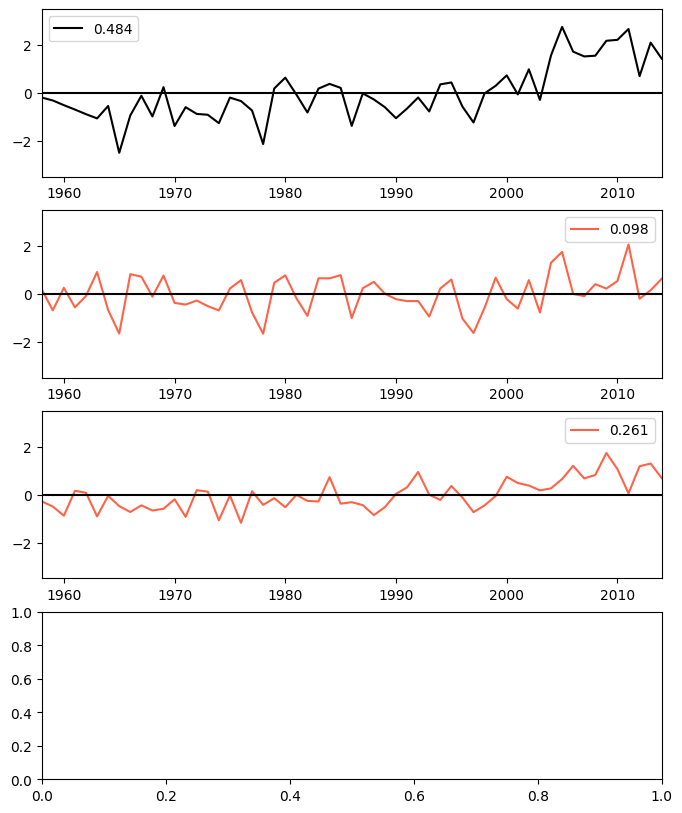

In [3]:
from sklearn.linear_model import LinearRegression

decades = np.arange(195.8, 201.5, 0.1)
fig, axs = plt.subplots(4,1, figsize=(8,10))
################################################################
tas_djf_trend = stats.linregress(x=decades, y=tas_djf)[0]
axs[0].plot(decades*10, tas_djf, color='black', label=str(tas_djf_trend)[:5])
axs[0].plot(decades*10, np.zeros(len(tas_djf)),color='black')
axs[0].set_ylim(-3.5,3.5)
axs[0].set_xlim(1958,2014)
axs[0].legend()
################################################################
dynamical_trend = stats.linregress(x=decades, y=tas_dynamically_induced)[0]
axs[1].plot(decades*10, tas_dynamically_induced, color='tomato', label=str(dynamical_trend)[:5])
axs[1].plot(decades*10, np.zeros(len(tas_djf)),color='black')
axs[1].set_ylim(-3.5,3.5)
axs[1].set_xlim(1958,2014)
axs[1].legend()
################################################################
tas_sic_trend = stats.linregress(x=decades, y=tas_sic_induced)[0]
axs[2].plot(decades*10, tas_sic_induced, color='tomato', label=str(tas_sic_trend)[:5])
axs[2].plot(decades*10, np.zeros(len(tas_djf)),color='black')
axs[2].set_ylim(-3.5,3.5)
axs[2].set_xlim(1958,2014)
axs[2].legend()
